In [15]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import emcee
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [16]:
df = pd.read_csv('../data/preliminary_results.csv')

In [17]:
df

,date,ew,ew_unc,int_wv,jd,qidx,star_name,time
0,2020-08-09,1.177059,0.038186,8542.0,2.459071e+06,4967.0,HAT-P-32_1_IN,08:23:13
1,2020-08-09,1.173182,0.030148,8542.0,2.459071e+06,4967.0,HAT-P-32_1_IN,08:37:26
2,2020-08-09,1.100334,0.025346,8542.0,2.459071e+06,4967.0,HAT-P-32_1_IN,08:51:38
3,2020-08-09,1.089765,0.022048,8542.0,2.459071e+06,4967.0,HAT-P-32_1_IN,09:05:51
4,2020-08-09,1.129137,0.022519,8542.0,2.459071e+06,4967.0,HAT-P-32_1_IN,09:20:04
5,2020-08-09,1.111387,0.025274,8542.0,2.459071e+06,4967.0,HAT-P-32_1_IN,09:34:17
6,2020-09-19,1.104340,0.029880,8542.0,2.459112e+06,6062.0,HAT-P-32_3_IN,05:42:56
7,2020-09-19,1.093289,0.025189,8542.0,2.459112e+06,6062.0,HAT-P-32_3_IN,05:57:09
8,2020-09-19,1.101152,0.022644,8542.0,2.459112e+06,6062.0,HAT-P-32_3_IN,06:11:22
9,2020-09-19,7.398148,5.315551,8542.0,2.459112e+06,6062.0,HAT-P-32_3_IN,06:25:35


In [18]:
target_mask = df.star_name.str.contains('HAT-P-32')

In [19]:
df = df[target_mask]

In [20]:
keep_mask = df.ew_unc < 1

In [21]:
df = df[keep_mask]

In [22]:
in_transit_mask = df.star_name.str.contains('_IN')

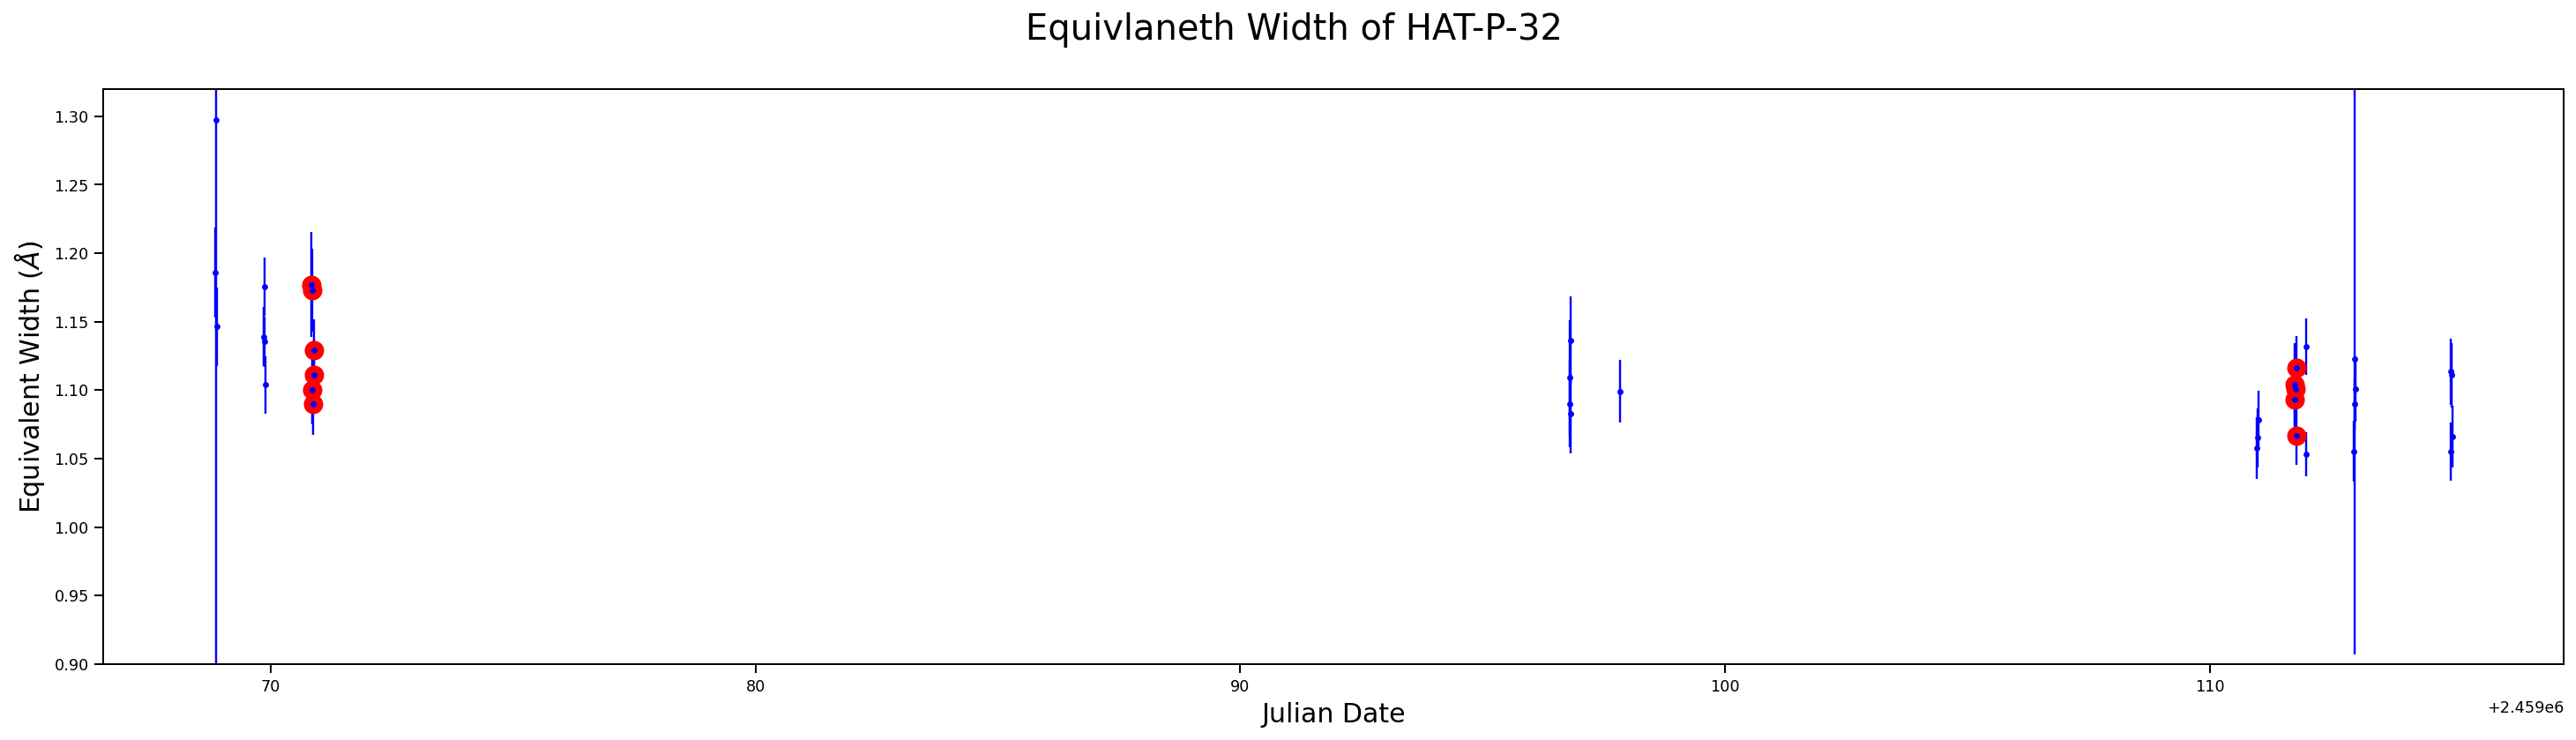

In [41]:
plt.figure(figsize=(25,6))
plt.errorbar(df.jd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.jd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(0.9,1.32)
plt.suptitle('Equivlaneth Width of HAT-P-32', fontsize=20)
plt.xlabel('Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig('HAT-P-32.jpg')

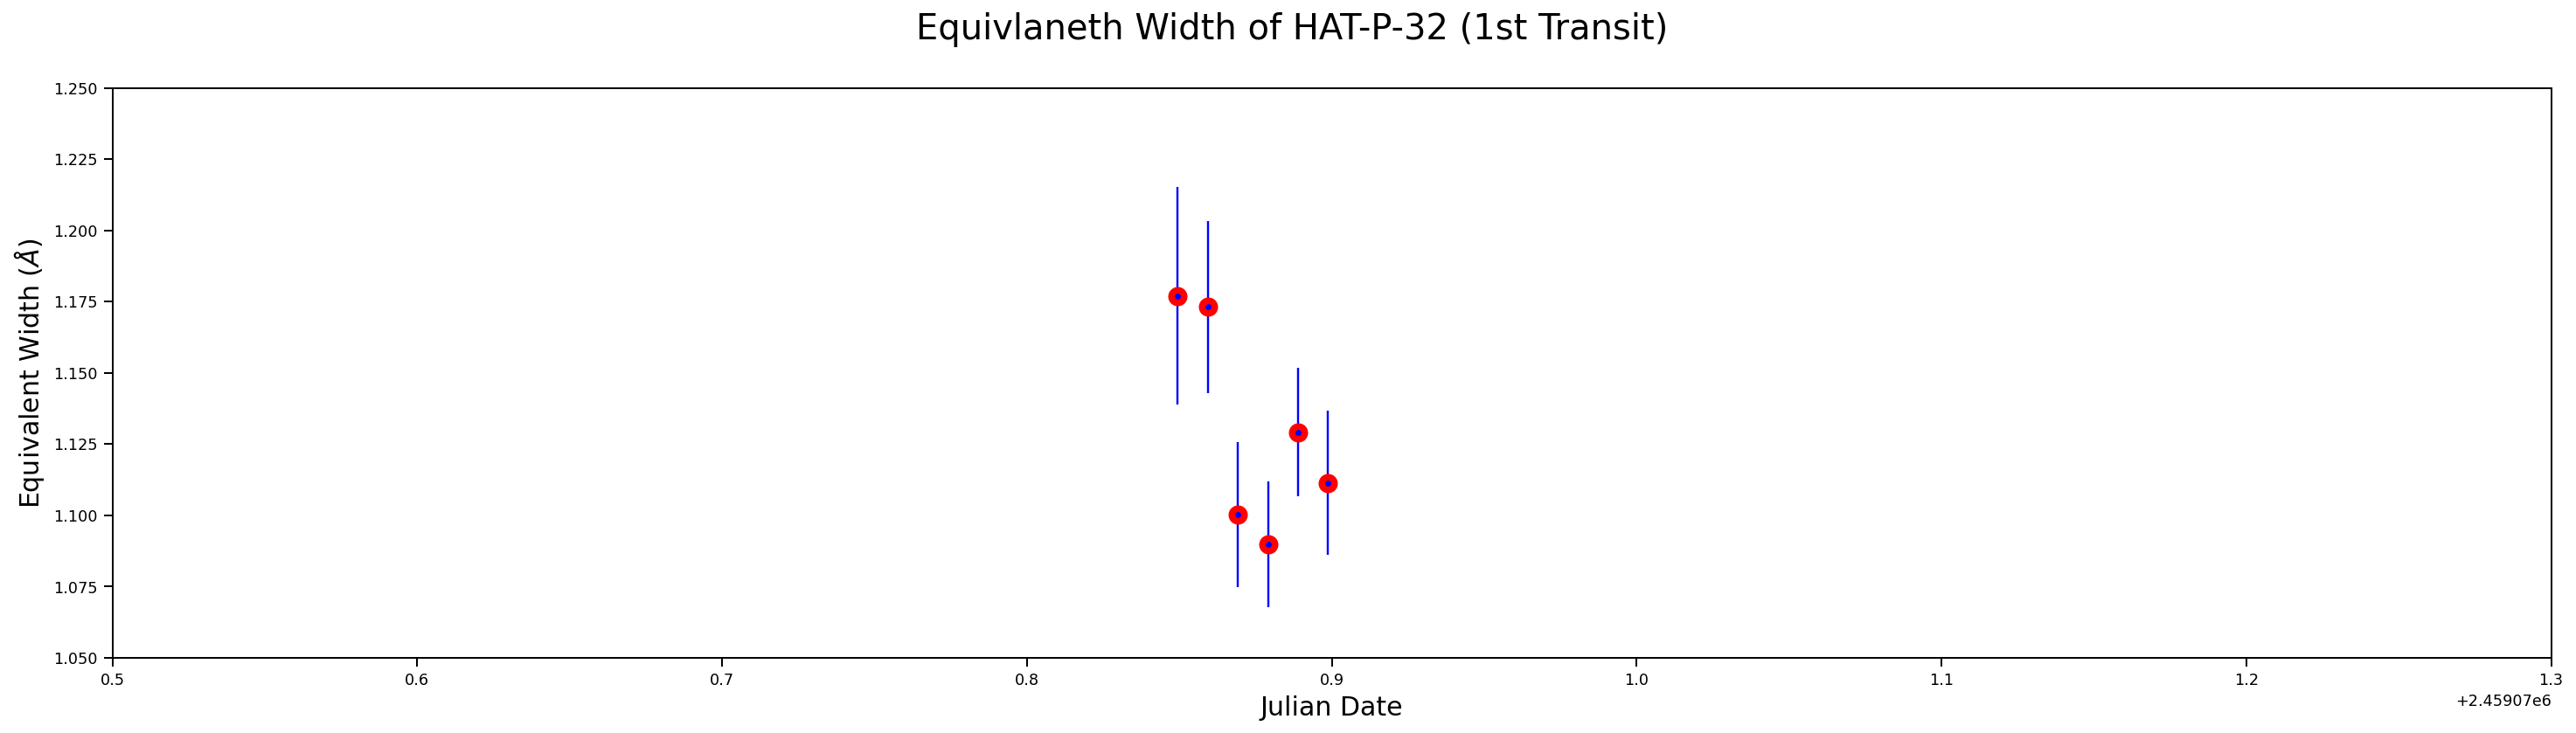

In [63]:
plt.figure(figsize=(25,6))
plt.errorbar(df.jd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.jd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(1.05,1.25)
plt.xlim(2.4590705e+06,2.4590713e+06)
plt.suptitle('Equivlaneth Width of HAT-P-32 (1st Transit)', fontsize=20)
plt.xlabel('Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig('IN_TRANSIT_1_HAT-P-32.jpg')

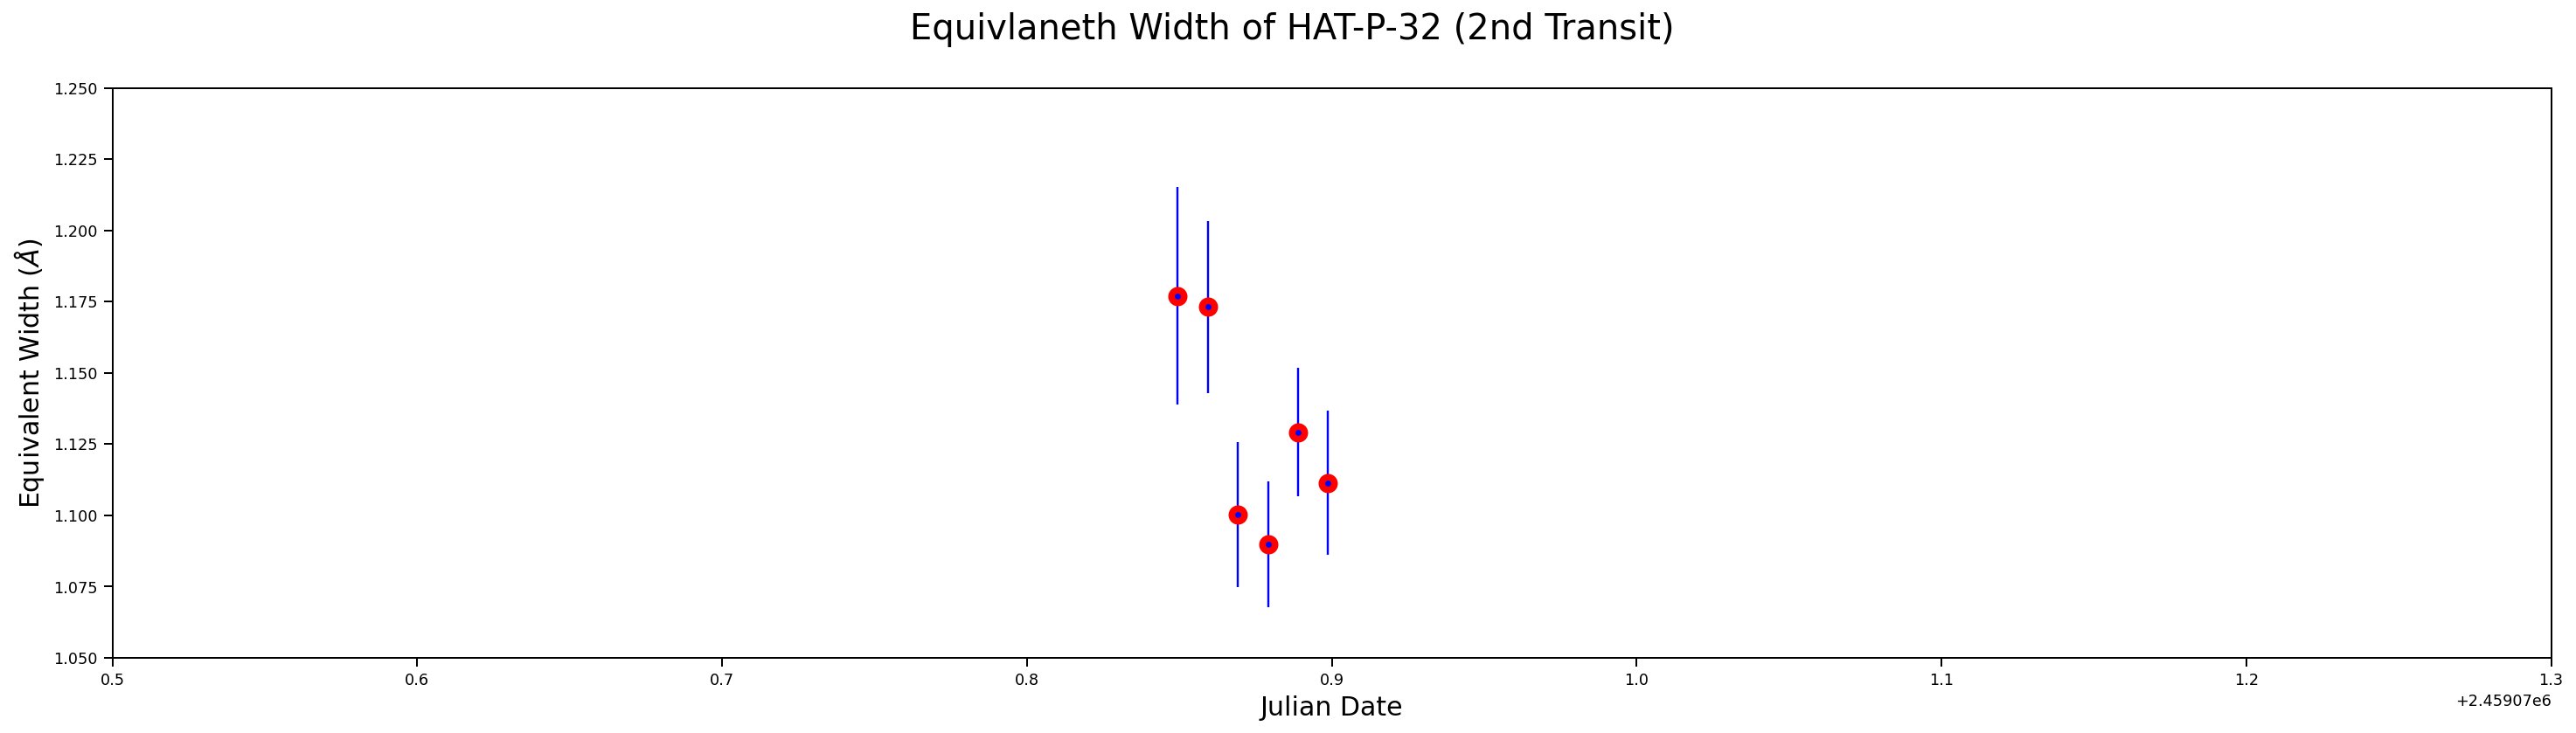

In [93]:
plt.figure(figsize=(25,6))
plt.errorbar(df.jd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.jd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(1.05,1.25)
plt.xlim(2.4590705e+06,2.4590713e+06)
plt.suptitle('Equivlaneth Width of HAT-P-32 (2nd Transit)', fontsize=20)
plt.xlabel('Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig('IN_TRANSIT_2_HAT-P-32.jpg')